## Consigna: Tendencias en las preferencias de cerveza
Este conjunto de datos contiene alrededor de 1,5 millones de reseñas de cervezas de BeerAdvocates. Su objetivo es caracterizar el conjunto de datos, agrupar cervezas similares y poder recomendar una cerveza, que preguntas podría responder utilizando los datos, por ejemplo: si tuviera que elegir 5 cervezas para recomendar, ¿cuál elegiría? ¿Por qué? ¿Cuáles de los factores (sabor, aroma, apariencia, paladar) son más importantes para determinar la la calidad general de una cerveza? Si por lo general disfruto de las IPA, ¿qué cerveza debo probar?

### Importar librerías

In [ ]:
import math
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [ ]:
import matplotlib.ticker as ticker

def improveCountPlot(ax,ncount):
  # Make twin axis
  ax2=ax.twinx()

  # Switch so count axis is on right, frequency on left
  ax2.yaxis.tick_left()
  ax.yaxis.tick_right()

  # Also switch the labels over
  ax.yaxis.set_label_position('right')
  ax2.yaxis.set_label_position('left')

  

  for p in ax.patches:
      x=p.get_bbox().get_points()[:,0]
      y=p.get_bbox().get_points()[1,1]
      ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
              ha='center', va='bottom') # set the alignment of the text

  # Use a LinearLocator to ensure the correct number of ticks
  ax.yaxis.set_major_locator(ticker.LinearLocator(11))

  # Fix the frequency range to 0-100
  ax2.set_ylim(0,100)
  ax.set_ylim(0,ncount)

  # And use a MultipleLocator to ensure a tick spacing of 10
  ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

  # Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
  ax2.grid(None)

### Cargar dataset

In [ ]:

beer_reviews_1 = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectBEE/data/beer_reviews_1.csv")
beer_reviews_1.describe()

,brewery_id,review_time,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,beer_beerid
count,871901.000000,8.719010e+05,871901.000000,871901.000000,871901.000000,871901.000000,871901.000000,835659.000000,871901.000000
mean,3271.796264,1.227348e+09,3.828825,3.755972,3.856491,3.757737,3.808603,7.046130,23337.928449
std,5644.054301,7.531277e+07,0.704718,0.677216,0.597753,0.662392,0.711305,2.330143,22030.109041
min,1.000000,8.406720e+08,0.000000,1.000000,0.000000,1.000000,1.000000,0.010000,3.000000
25%,140.000000,1.179688e+09,3.500000,3.500000,3.500000,3.500000,3.500000,5.300000,2151.000000
50%,590.000000,1.243041e+09,4.000000,4.000000,4.000000,4.000000,4.000000,6.500000,17770.000000
75%,2743.000000,1.289962e+09,4.500000,4.000000,4.000000,4.000000,4.500000,8.500000,41722.000000
max,28003.000000,1.326285e+09,5.000000,5.000000,5.000000,5.000000,5.000000,57.700000,77314.000000


In [ ]:

beer_reviews_2 = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectBEE/data/beer_reviews_2.csv")
beer_reviews_2.describe()

,brewery_id,review_time,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,beer_beerid
count,714713.000000,7.147130e+05,714713.000000,714713.000000,714713.000000,714713.000000,714713.000000,683170.000000,714713.000000
mean,2957.238473,1.220114e+09,3.799424,3.710828,3.823527,3.726578,3.773655,7.037808,19730.241690
std,5491.633209,7.783588e+07,0.739240,0.720948,0.637284,0.705274,0.755971,2.313168,21390.648054
min,4.000000,8.853408e+08,1.000000,1.000000,1.000000,1.000000,1.000000,0.050000,10.000000
25%,147.000000,1.166726e+09,3.500000,3.500000,3.500000,3.500000,3.500000,5.200000,1381.000000
50%,367.000000,1.234357e+09,4.000000,4.000000,4.000000,4.000000,4.000000,6.500000,8984.000000
75%,1941.000000,1.286605e+09,4.500000,4.000000,4.000000,4.000000,4.500000,8.500000,36087.000000
max,27984.000000,1.326275e+09,5.000000,5.000000,5.000000,5.000000,5.000000,39.000000,77317.000000


In [ ]:
reviews = beer_reviews_1.append(beer_reviews_2,ignore_index=True)

Vamos a renombrar las columnas para mayor claridad

In [ ]:
reviews.columns = ['brewery_id', 'brewery_name', 'time', 'overall',
       'aroma', 'appearance', 'profilename', 'beer_style',
       'palate', 'taste', 'name', 'alcohol_by_volume',
       'beerid']
reviews['review_id'] = reviews.index

## Análisis exploratorio

### Datos faltantes

Chequear si hay datos faltantes

In [ ]:
print('Cantidad de registros ',len(reviews))
print("Datos faltantes del Dataset: \n",reviews.isnull().sum())
reviews = reviews.dropna(axis = 0)
print('Nueva cantidad de registros {}'.format(len(reviews)))

Cantidad de registros  1586614
Datos faltantes del Dataset: 
 brewery_id               0
brewery_name            15
time                     0
overall                  0
aroma                    0
appearance               0
profilename            348
beer_style               0
palate                   0
taste                    0
name                     0
alcohol_by_volume    67785
beerid                   0
review_id                0
dtype: int64
Nueva cantidad de registros 1518478


In [ ]:
print('¿Cuantas veces un mismo usuario hizo review para el mismo tipo/modelo de cerveza más de una vez?: {}'.format(len(reviews.duplicated(['profilename','name']))))



¿Cuantas veces un mismo usuario hizo review para el mismo tipo/modelo de cerveza más de una vez?: 1518478


In [ ]:
reviews = reviews.sort_values('overall',ascending= False)
reviews = reviews.drop_duplicates(subset=['profilename','name'],keep = 'first')
reviews = reviews.drop_duplicates(subset=['profilename','beerid'],keep = 'first')
reviews.shape

(1496263, 14)

In [ ]:
print('Cantidad de usuarios que dieron un review: ',reviews.profilename.nunique())
print('Cantidad de marcas de cervezas o cervecerías (breweries): ',reviews.brewery_name.nunique())
print('Cantidad de estilos de cerveza (styles): ',reviews.beer_style.nunique())
print('Cantidad de tipos/modelos de cerveza (names): ',reviews.name.nunique())

Cantidad de usuarios que dieron un review:  32908
Cantidad de marcas de cervezas o cervecerías (breweries):  5139
Cantidad de estilos de cerveza (styles):  104
Cantidad de tipos/modelos de cerveza (names):  44075


###Análisis inicial de la distribución de atributos en las reviews

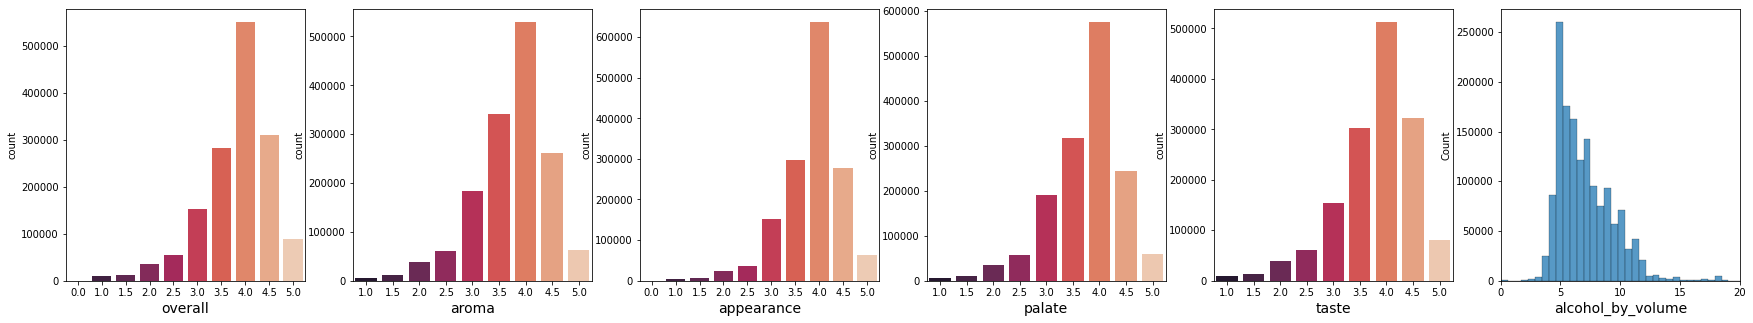

In [ ]:
features = ['overall','aroma', 'appearance', 'palate', 'taste','alcohol_by_volume']
fig,axs = plt.subplots(1,6,figsize=(30,5))
for ax,feature in zip(axs,features):
  if feature=='alcohol_by_volume':
    sns.histplot(data=reviews,x=feature,ax=ax,bins=100)
    ax.set_xlim((0,20))
  else:
    sns.countplot(data=reviews,x=feature,ax=ax,palette='rocket')
  
  ax.set_xlabel(feature,fontdict={'size':14})


In [ ]:
reviews[features[:-1]].describe()

,overall,aroma,appearance,palate,taste
count,1.496263e+06,1.496263e+06,1.496263e+06,1.496263e+06,1.496263e+06
mean,3.825543e+00,3.746414e+00,3.850305e+00,3.754193e+00,3.804597e+00
std,7.176279e-01,6.953734e-01,6.144135e-01,6.793402e-01,7.287301e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
25%,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00
50%,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
75%,4.500000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.500000e+00
max,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00


Los atributos que son calificados por los usuarios tienen distribuciones similares. Todos tienen una mediana de 4, con un valor medio entre 3.7 y 3.8, y con un desvío similar y pequeño (alrededor de 0.6 puntos). El atributo con mayor desviación estándar es el Taste, con 0.73. Los atributos de apariencia y overall son los únicos que tienen al menos una calificación de 0. El resto, tienen como calificación mínima un 1. Todos los atributos tienen al menos una calificación de 5 puntos. 

Veamos un plot detallado que incluya también las frecuencias de cada calificación 



Text(0, 0.5, 'Frecuencia [%]')

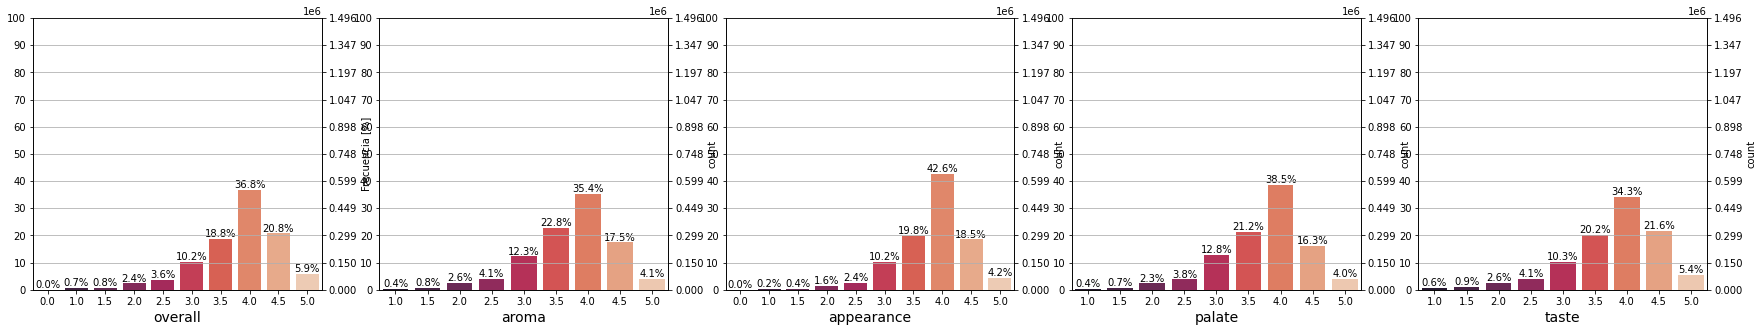

In [ ]:
fig,axs = plt.subplots(1,5,figsize=(30,5))
for ax,feature in zip(axs,features[:-1]):
  ax.set_ylabel('')
  sns.countplot(data=reviews,x=feature,ax=ax,palette='rocket')
  improveCountPlot(ax,len(reviews))
  ax.set_xlabel(feature,fontdict={'size':14})
axs[0].yaxis.set_label_position('right')
axs[0].set_ylabel('Frecuencia [%]')
  

Vemos que los puntajes de 0 son una cantidad insignificante.

Evaluemos la correlación de los cuatro factores con el overall

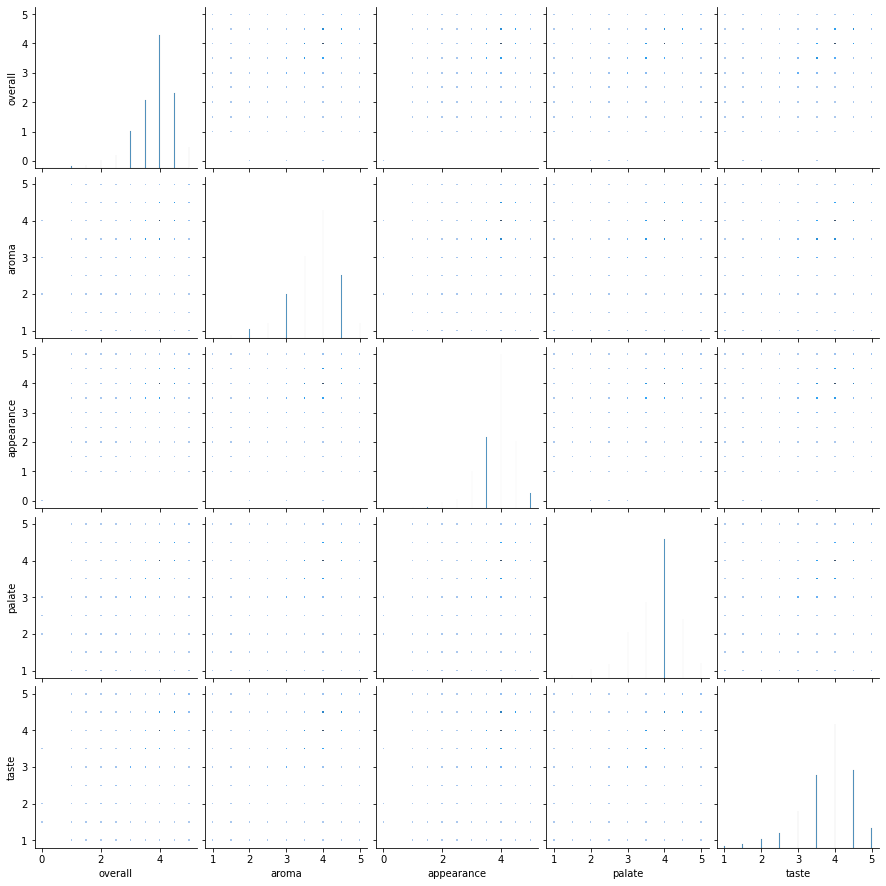

In [ ]:
scores = reviews[['overall','aroma','appearance','palate','taste']]
sns.pairplot(scores, kind="hist")

Resulta incómodo evaluar correlación gráficamente para datos categóricos, no es posible sacar una conclusión relevante

###Análisis de marcas populares
¿Cuáles son las marcas de cerveza con más cantidad de calificaciones, es decir, las más populares? ¿Y cuál es el promedio de la calificación overall de esas marcas?

In [ ]:
overall_reviews = reviews.groupby('brewery_name').agg({'overall': ['mean', 'count']}).reset_index()
overall_reviews.columns = overall_reviews.columns.droplevel(0)
overall_reviews.columns = ['Marca (brewery_name)', 'Promedio de puntaje', 'Cantidad de reviews']
overall_reviews = overall_reviews.sort_values('Cantidad de reviews', ascending=False)
overall_reviews.head(10)


,Marca (brewery_name),Promedio de puntaje,Cantidad de reviews
631,Boston Beer Company (Samuel Adams),3.692536,38533
1788,Dogfish Head Brewery,3.837397,33348
4443,Stone Brewing Co.,4.041931,32482
4260,Sierra Nevada Brewing Co.,4.058172,28235
372,"Bell's Brewery, Inc.",3.973081,24611
4046,Rogue Ales,3.914804,22912
2051,Founders Brewing Company,4.115772,19655
4882,Victory Brewing Company,3.996848,19033
2886,Lagunitas Brewing Company,3.955640,16659
208,Avery Brewing Company,3.814997,15816


In [ ]:
overall_reviews['Cantidad de reviews'].describe()

count     5139.000000
mean       291.158397
std       1545.848560
min          1.000000
25%          3.000000
50%         12.000000
75%         71.000000
max      38533.000000
Name: Cantidad de reviews, dtype: float64

Vemos que la cantidad promedio de reviews que obtuvo cada marca de cerveza es 291 reviews, con un desvío alto de 1545. El 75% de las marcas tienen menos de 71 calificaciones. Esto sugiere que hay un puñado pequeño de marcas que son las más populares y concentran la mayoría de las reviews. 

Veamos la distribución de cantidad de calificaciones para el 1% de marcas más populares, es decir, con mayor cantidad de reviews.

In [ ]:
overall_reviews['Cantidad de reviews'].quantile(0.99)

5701.399999999992

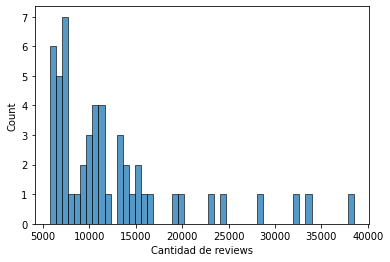

In [ ]:
populares = overall_reviews[overall_reviews['Cantidad de reviews']>overall_reviews['Cantidad de reviews'].quantile(0.99)]
sns.histplot(populares['Cantidad de reviews'],bins=50)                                

In [ ]:
reviews_populares = reviews[reviews.brewery_name.isin(populares['Marca (brewery_name)'])]

print('{} marcas (de entre un total de {}) concentran el {:.1f}% de las reviews'.format(len(populares), len(set(reviews.brewery_name)),
                                                                                        100*len(reviews_populares)/len(reviews)))

print("La marca más popular es {} con {} reviews.".format(populares['Marca (brewery_name)'].values[0],
                                                          populares['Cantidad de reviews'].values[0]))


52 marcas (de entre un total de 5139) concentran el 43.5% de las reviews
La marca más popular es Boston Beer Company (Samuel Adams) con 38533 reviews.


Al parecer los estudiantes de las universidades de Boston postean muchas reviews y toman mucha cerveza ...

In [ ]:
marcas_populares = populares['Marca (brewery_name)']

### Análisis puntaje overall

¿Cuales son las marcas con una calificación overall de 5 puntos? ¿Cuántas reviews tuvo cada una? 

In [ ]:
topOveralls=reviews[reviews.overall==5].groupby('brewery_name').agg({"review_id":"count",
                                                                     "profilename":"nunique"}).sort_values(by="review_id",ascending=False)
topOveralls.columns = ['Cantidad de reviews','Cantidad de usuarios que calificaron']

print(topOveralls)

                                                    Cantidad de reviews  Cantidad de usuarios que calificaron
brewery_name                                                                                                 
Stone Brewing Co.                                                  2685                                  1771
Russian River Brewing Company                                      2669                                  1689
Founders Brewing Company                                           2214                                  1558
Sierra Nevada Brewing Co.                                          2191                                  1594
Bell's Brewery, Inc.                                               2157                                  1562
...                                                                 ...                                   ...
Barley Days Brewery                                                   1                                     1
River Hous

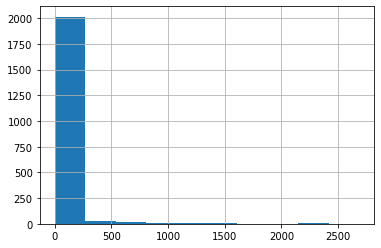

In [ ]:
topOveralls['Cantidad de reviews'].hist()

In [ ]:
topOveralls99 =  topOveralls[topOveralls['Cantidad de reviews'] > topOveralls['Cantidad de reviews'].quantile(0.99)]
print(len(topOveralls),len(topOveralls99))

2087 21


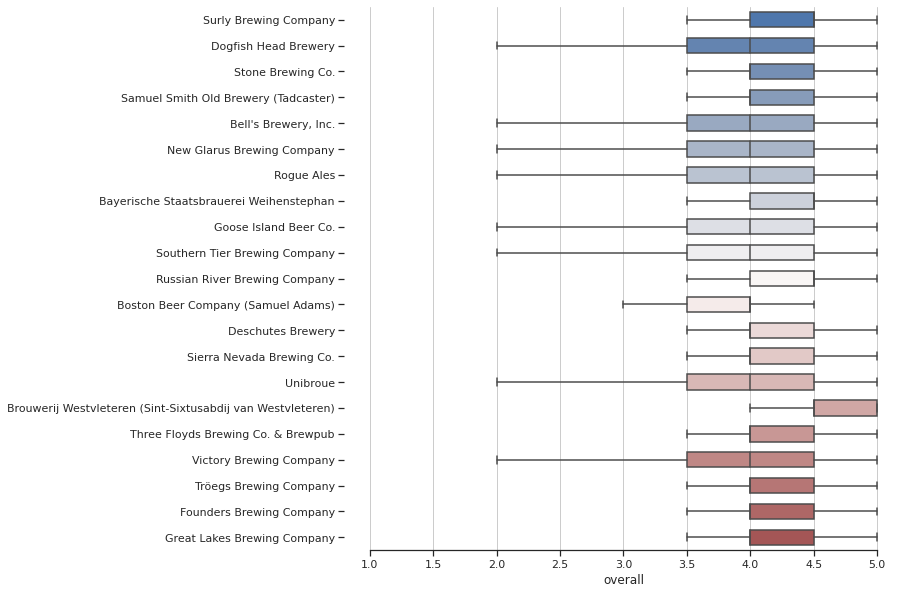

In [ ]:
sns.set_theme(style="ticks")
topOveralls99_reviews = reviews[reviews.brewery_name.isin(topOveralls99.index)]
f, ax = plt.subplots(figsize=(10, 10))
#ax.set_xscale("log")

sns.boxplot(x="overall", y="brewery_name", data=topOveralls99_reviews,
            #whis=[0, 100], 

            fliersize=0,
            width=.6, palette="vlag")

ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

Surly Brewing Company es la marca con mayor cantidad de reviews con calificación overall de 5 puntos. Se destaca tambien Brouwerij Westvleteren por ser la marca con una distirbución más concentrada alrededor del 5 para su puntaje overall

¿Cuáles marcas están en común en ambos análisis? Es decir, son marcas populares y con un puntaje overall consistentemente alto

In [ ]:
mejores_marcas = set(topOveralls99.index).intersection(marcas_populares)

print('Hay {} marcas que son populares (alta cantidad de reveiws) y buenas (altas calificaciones overall. Estas son: \n\n{}'.format(len(mejores_marcas),
                                                                                                                                '\n'.join(list(mejores_marcas))))

Hay 20 marcas que son populares (alta cantidad de reveiws) y buenas (altas calificaciones overall. Estas son: 

Southern Tier Brewing Company
Great Lakes Brewing Company
Founders Brewing Company
Surly Brewing Company
New Glarus Brewing Company
Tröegs Brewing Company
Samuel Smith Old Brewery (Tadcaster)
Deschutes Brewery
Victory Brewing Company
Unibroue
Bell's Brewery, Inc.
Dogfish Head Brewery
Bayerische Staatsbrauerei Weihenstephan
Three Floyds Brewing Co. & Brewpub
Stone Brewing Co.
Boston Beer Company (Samuel Adams)
Russian River Brewing Company
Sierra Nevada Brewing Co.
Goose Island Beer Co.
Rogue Ales


Text(0, 0.5, 'Calidad según calificaciones \n(promedio de puntaje overall)')

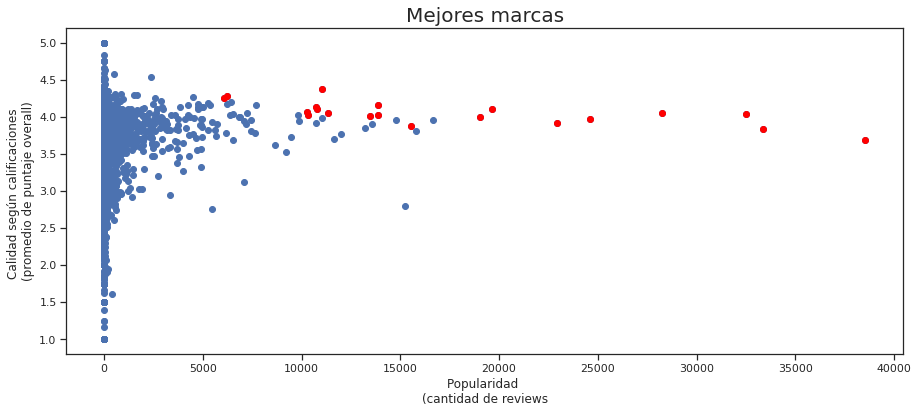

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(15,6))
ax.scatter(overall_reviews['Cantidad de reviews'],overall_reviews['Promedio de puntaje'])
ax.scatter(overall_reviews[overall_reviews['Marca (brewery_name)'].isin(mejores_marcas)]['Cantidad de reviews'],
           overall_reviews[overall_reviews['Marca (brewery_name)'].isin(mejores_marcas)]['Promedio de puntaje'],color='red')
ax.set_title('Mejores marcas',fontdict={'size':20,'weight':10})
ax.set_xlabel('Popularidad \n(cantidad de reviews')
ax.set_ylabel('Calidad según calificaciones \n(promedio de puntaje overall)')

### Análisis temporal

Evaluemos el dato de "time", y cómo variaron las reviews registradas a lo largo del tiempo

In [ ]:
reviews.time = pd.to_datetime(reviews.time,unit = 's')
print('Evolución año a año')
print(reviews[['review_id','brewery_name', 'profilename', 'beer_style',
       'name']].groupby(reviews['time'].dt.year).agg({"nunique"}))


Evolución año a año
     review_id brewery_name profilename beer_style    name
       nunique      nunique     nunique    nunique nunique
time                                                      
1998        71           36           3         44      71
1999        31           21           3         23      31
2000        95           67           5         47      94
2001      1741          329          72         87     849
2002     20262          968         397         98    3591
2003     50911         1598         958        102    6561
2004     63519         1822        1553        103    7868
2005     82116         2010        2801        103    9260
2006    120393         2270        4764        104   11020
2007    133571         2305        6458        104   11328
2008    198418         2552        7830        104   13514
2009    231892         2812        9481        104   15876
2010    264868         3049       10352        104   18438
2011    319098         3470       11

Vemos que las reviews aumentaron notablemente en los últimos años, y también aparecieron nuevas marcas de cerveza, nuevos estilos, y nuevos tipos (names). El dataset seguramente se cerró a comienzos del año 2012, porque este año tiene muy pocos registros. 

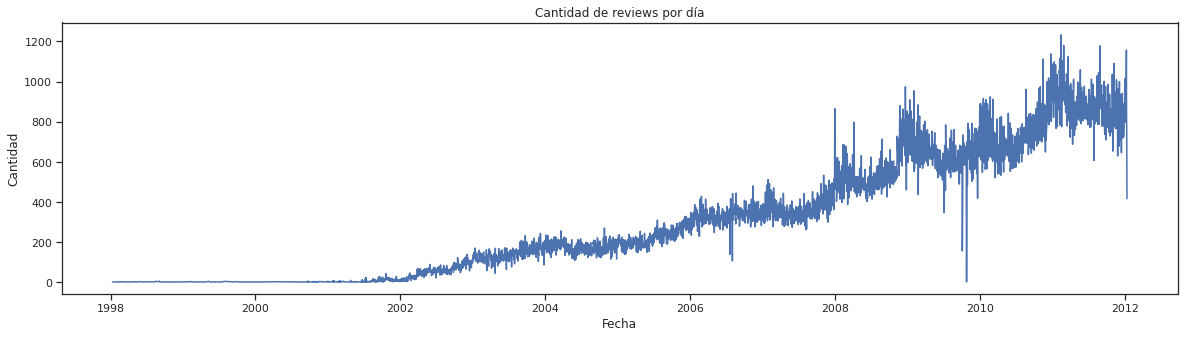

In [ ]:
group_by_date = reviews[ [ 'time' ] ].groupby(reviews[ 'time' ].dt.date ).agg( [ 'count' ] )
plt.figure( figsize = ( 20, 5 ) )
plt.plot( group_by_date )
plt.xlabel( 'Fecha' )
plt.ylabel( 'Cantidad' )

plt.title( 'Cantidad de reviews por día' )
plt.show()

In [ ]:
counts_per_year = reviews[['brewery_name', 'profilename', 'beer_style',
       'name']].groupby(reviews['time'].dt.year).agg({"nunique"})


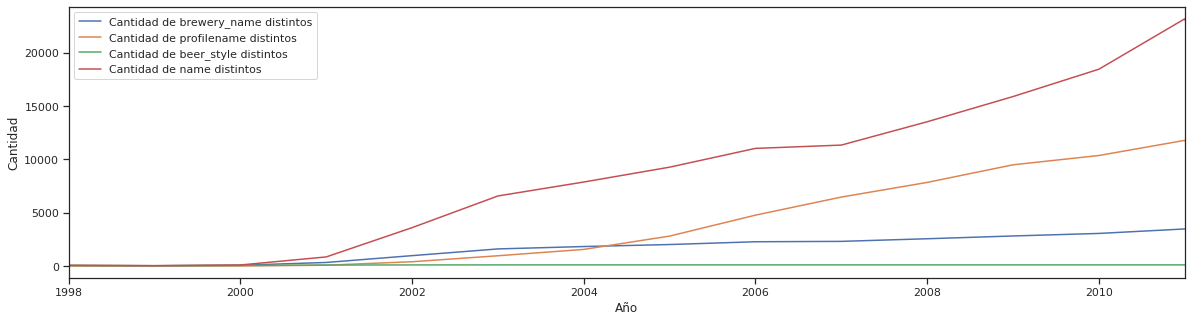

In [ ]:
plt.figure( figsize = ( 20, 5 ) )
for column in counts_per_year.columns:
  plt.plot(counts_per_year[column],label="Cantidad de {} distintos".format(column[0]))
plt.xlabel( 'Año' )
plt.xlim((1998,2011))
plt.ylabel( 'Cantidad' )
plt.legend()
plt.show()

### Análisis de los tipos de cerveza y sus estilos

In [ ]:
top10_popular_styles = pd.DataFrame(reviews.groupby('beer_style').beer_style.count().sort_values(ascending = False).iloc[0:10])
top10_popular_styles.columns = ['Estilos con mayor cantidad de reviews']
top10_popular_styles

,Estilos con mayor cantidad de reviews
beer_style,
American IPA,110451
American Double / Imperial IPA,83635
American Pale Ale (APA),56750
Russian Imperial Stout,52323
American Double / Imperial Stout,49254
American Porter,45960
American Amber / Red Ale,41198
Belgian Strong Dark Ale,37181
Fruit / Vegetable Beer,31784


In [ ]:
popular_beers = pd.DataFrame(reviews.groupby('name').name.count().sort_values(ascending = False))[:100]  #Hacemos mil para que no tarde tanto

popular_beers.columns = ['Cantidad de reviews']
popular_beers['Marca'] = [reviews[reviews.name==n].brewery_name.values[0] for n in popular_beers.index]
popular_beers['Estilo'] = [reviews[reviews.name==n].beer_style.values[0] for n in popular_beers.index]
popular_beers['Overall promedio'] = [reviews[reviews.name==n].overall.mean() for n in popular_beers.index]
popular_beers[:10]


,Cantidad de reviews,Marca,Estilo,Overall promedio
name,,,,
90 Minute IPA,3206,Dogfish Head Brewery,American Double / Imperial IPA,4.149719
Old Rasputin Russian Imperial Stout,3038,North Coast Brewing Co.,Russian Imperial Stout,4.177090
Sierra Nevada Celebration Ale,2929,Sierra Nevada Brewing Co.,American IPA,4.172072
Stone Ruination IPA,2644,Stone Brewing Co.,American Double / Imperial IPA,4.165469
Arrogant Bastard Ale,2633,Stone Brewing Co.,American Strong Ale,4.082605
Two Hearted Ale,2631,"Bell's Brewery, Inc.",American IPA,4.332763
Stone IPA (India Pale Ale),2526,Stone Brewing Co.,American IPA,4.260095
Sierra Nevada Pale Ale,2526,Sierra Nevada Brewing Co.,American Pale Ale (APA),4.252375
La Fin Du Monde,2480,Unibroue,Tripel,4.297984


¿Alguno de estos top 10 es una cerveza de una de las mejores marcas que encontramos antes?

In [ ]:
popular_beers = popular_beers[popular_beers['Marca'].isin(mejores_marcas)].sort_values(by='Overall promedio',ascending=False)
popular_beers = popular_beers.iloc[:10]
popular_beers

,Cantidad de reviews,Marca,Estilo,Overall promedio
name,,,,
Pliny The Elder,2432,Russian River Brewing Company,American Double / Imperial IPA,4.598273
Weihenstephaner Hefeweissbier,1951,Bayerische Staatsbrauerei Weihenstephan,Hefeweizen,4.517683
The Abyss,1366,Deschutes Brewery,American Double / Imperial Stout,4.452050
Founders KBS (Kentucky Breakfast Stout),1875,Founders Brewing Company,American Double / Imperial Stout,4.402667
Tröegs Nugget Nectar,1879,Tröegs Brewing Company,American Amber / Red Ale,4.394625
Bell's Hopslam Ale,2347,"Bell's Brewery, Inc.",American Double / Imperial IPA,4.380486
Founders Breakfast Stout,2443,Founders Brewing Company,American Double / Imperial Stout,4.359394
Alpha King Pale Ale,1496,Three Floyds Brewing Co. & Brewpub,American Pale Ale (APA),4.332888
Two Hearted Ale,2631,"Bell's Brewery, Inc.",American IPA,4.332763


Concluimos que estas 10 cervezas son recomendables. 

La mayoría son IPA, asi que para encontrar unas 5 finalistas a recomendar, vamos a eliminar duplicados de estilos y reevaluar

In [ ]:
popular_beers = popular_beers.drop_duplicates('Estilo')
#popular_beers = popular_beers[popular_beers['Marca'].isin(mejores_marcas)].sort_values(by='Overall promedio',ascending=False)
top_5_beers = popular_beers.iloc[:5]
top_5_beers

,Cantidad de reviews,Marca,Estilo,Overall promedio
name,,,,
Pliny The Elder,2432,Russian River Brewing Company,American Double / Imperial IPA,4.598273
Weihenstephaner Hefeweissbier,1951,Bayerische Staatsbrauerei Weihenstephan,Hefeweizen,4.517683
The Abyss,1366,Deschutes Brewery,American Double / Imperial Stout,4.452050
Tröegs Nugget Nectar,1879,Tröegs Brewing Company,American Amber / Red Ale,4.394625
Alpha King Pale Ale,1496,Three Floyds Brewing Co. & Brewpub,American Pale Ale (APA),4.332888


Recomendamos estas 5 cervezas porque son de marcas populares y con buenas calificaciones, y porque son las más calificadas para cada estilo.

Si te gusta beber IPAs tenés que probar la Pliny The Elder 

## Clustering


### Preparacion
Dado que las recomendaciones se dan a nivel cerveza (beer name), haremos un clustering a este nivel. El objetivo es identificar grupos de cervezas según sus promedios de calificaciones para cada atributo y su popularidad, entre otros factores. 

Para eso creamos un dataframe donde la unidad sea el beer name.


In [ ]:
beers = reviews.groupby('name').agg({'review_id':'count',
                                     'overall':'mean',
                                     'taste':'mean',
                                     'palate':'mean',                                     
                                     'aroma':'mean',
                                     'appearance':'mean',
                                     'alcohol_by_volume':'mean',
                                     'profilename':'nunique',
                                     }).sort_values('review_id',ascending=False)

In [ ]:
print(len(beers))
beers[:15]

44075


,review_id,overall,taste,palate,aroma,appearance,alcohol_by_volume,profilename
name,,,,,,,,
90 Minute IPA,3206,4.149719,4.327667,4.180443,4.216157,4.192608,9.0,3206
Old Rasputin Russian Imperial Stout,3038,4.177090,4.343976,4.232225,4.200461,4.370639,9.0,3038
Sierra Nevada Celebration Ale,2929,4.172072,4.191192,4.076135,4.082963,4.224821,6.8,2929
Stone Ruination IPA,2644,4.165469,4.351929,4.184947,4.343608,4.180219,7.7,2644
Arrogant Bastard Ale,2633,4.082605,4.280668,4.147171,4.120585,4.297569,7.2,2633
Two Hearted Ale,2631,4.332763,4.319080,4.136830,4.265488,4.152223,7.0,2631
Stone IPA (India Pale Ale),2526,4.260095,4.297110,4.138559,4.240499,4.134402,6.9,2526
Sierra Nevada Pale Ale,2526,4.252375,4.117973,3.971298,3.915479,3.995645,5.6,2526
La Fin Du Monde,2480,4.297984,4.395968,4.264315,4.231653,4.193750,9.0,2480


Para aquellas cervezas con muy poca cantidad de opiniones, los datos que tenemos de ellas no son suficientes para encontrar conclusiones generalizables. Por eso, para hacer un clustering relevante, vamos a trabajar únicamente con los tipos de cerveza que se encuentren en el cuartil superior de cantidad de reviews. 

In [ ]:
for q in [0.75,0.95,0.99]:
  min_review_count = beers.review_id.quantile(q)
  beers_reduced = beers[beers.review_id>min_review_count]
  print("cuantil: ",q,
        "cantidad de reviews: ",int(min_review_count),
        "cantidad de cervezas que cumplen: ",len(beers_reduced))

cuantil:  0.75 cantidad de reviews:  12 cantidad de cervezas que cumplen:  10829
cuantil:  0.95 cantidad de reviews:  151 cantidad de cervezas que cumplen:  2195
cuantil:  0.99 cantidad de reviews:  627 cantidad de cervezas que cumplen:  441


Elegimos el cuantil 0.75

In [ ]:
beers = beers[beers.review_id>12]

Normalizamos los datos porque trabajaremos con distancias entre features

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scl = MinMaxScaler()
beers_norm = scl.fit_transform(beers.values)
beers_norm = pd.DataFrame(beers_norm,columns=beers.columns)


In [ ]:
beers_norm.head()

,review_id,overall,taste,palate,aroma,appearance,alcohol_by_volume,profilename
0,1.000000,0.811382,0.842034,0.825591,0.834410,0.845355,0.213759,1.000000
1,0.947385,0.818795,0.846361,0.840085,0.829846,0.906191,0.213759,0.947385
2,0.913248,0.817436,0.805826,0.796396,0.795686,0.856363,0.159705,0.913248
3,0.823990,0.815648,0.848471,0.826852,0.871464,0.841122,0.181818,0.823990
4,0.820545,0.793206,0.829565,0.816278,0.806624,0.881222,0.169533,0.820545


### Elbow para estimar n_clusters

Probamos clusterizar solo con los scores de reviews

783.3515160340602
347.8273378077573
200.72904938593035
149.20383526921793
116.90096376574918
100.29835335520039
89.91971270737244
81.93200694855581
77.31550913160137


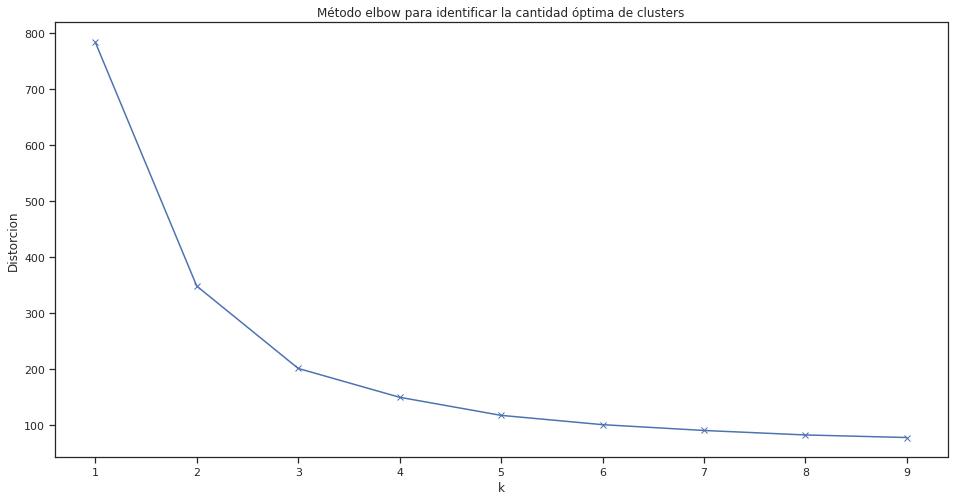

In [ ]:
from sklearn.cluster import KMeans

scores_df = beers_norm[['taste','appearance','palate','aroma','overall']]
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(scores_df)
    distortions.append(kmeanModel.inertia_)
    print(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distorcion')
plt.title('Método elbow para identificar la cantidad óptima de clusters')
plt.show()

In [ ]:
cluster_5features = KMeans(n_clusters=2, random_state=0).fit(scores_df.values)
y = cluster_5features.predict(scores_df.values)
pd.DataFrame(cluster_5features.cluster_centers_,
             columns=['taste','appearance','palate','aroma','overall']).describe()


,taste,appearance,palate,aroma,overall
count,2.000000,2.000000,2.000000,2.000000,2.000000
mean,0.613077,0.642550,0.624651,0.608237,0.646852
std,0.156240,0.149233,0.142836,0.163131,0.135529
min,0.502599,0.537026,0.523650,0.492885,0.551018
25%,0.557838,0.589788,0.574150,0.550561,0.598935
50%,0.613077,0.642550,0.624651,0.608237,0.646852
75%,0.668317,0.695312,0.675151,0.665912,0.694769
max,0.723556,0.748074,0.725651,0.723588,0.742685


In [ ]:
pd.Series(y).value_counts()

0    8299
1    2530
dtype: int64

Para visualizar los clusters elegimos los tres atributos con mayor variabilidad y hacemos un plot tridimensional

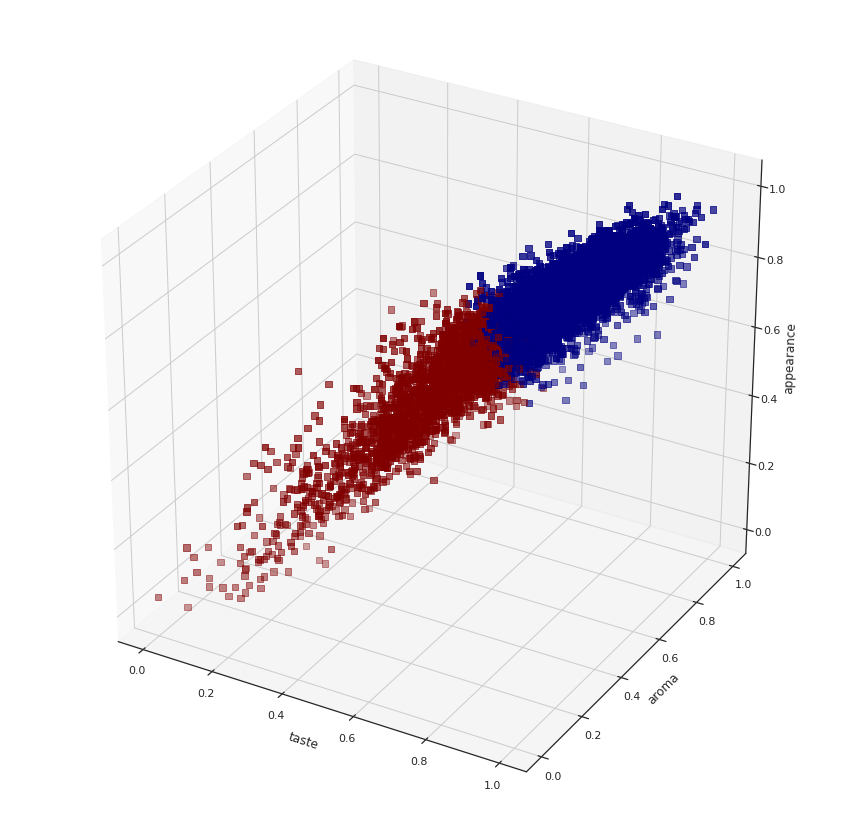

In [ ]:
threefeatures = scores_df[['aroma','taste','appearance']]
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
x1 = np.array(threefeatures.values[:,1])
x2 = np.array(threefeatures.values[:,0])
x3 = np.array(threefeatures.values[:,2])

ax.set_ylabel('aroma')
ax.set_xlabel('taste')
ax.set_zlabel('appearance')
ax.scatter(x1,x2,x3, marker="s", c=y, s=40, cmap="jet")
plt.show()

Parece que hay un cluster de cervezas con peor sabor, aroma y apariencia (rojo) y otro con estos valores más altos (azul).

In [ ]:
#beers['beer_style'] = [reviews[reviews.name==n]['beer_style'].values[0] for n in beers.index]
names = {0:'azul',1:'rojo'}
for cluster_number in range(2):
  print(names[cluster_number])
  print(beers[y==cluster_number].beer_style.value_counts()[:15])
    

azul
American IPA                        614
American Double / Imperial IPA      406
American Pale Ale (APA)             357
American Porter                     306
American Double / Imperial Stout    246
American Amber / Red Ale            240
Russian Imperial Stout              237
Saison / Farmhouse Ale              228
Belgian Strong Pale Ale             203
Belgian Strong Dark Ale             202
American Barleywine                 174
Tripel                              172
American Wild Ale                   171
American Strong Ale                 165
Hefeweizen                          152
Name: beer_style, dtype: int64
rojo
American Adjunct Lager      235
Euro Pale Lager             149
Fruit / Vegetable Beer      118
American Pale Ale (APA)     117
American Amber / Red Ale    109
American Pale Wheat Ale     100
German Pilsener              95
Light Lager                  88
American Blonde Ale          88
American Pale Lager          70
American IPA                 68
English

In [ ]:
for cluster_number in range(2):
  print(names[cluster_number])
  namesbeers = beers[y==cluster_number].index[:15]
  
  print(namesbeers.values)

azul
['90 Minute IPA' 'Old Rasputin Russian Imperial Stout'
 'Sierra Nevada Celebration Ale' 'Stone Ruination IPA'
 'Arrogant Bastard Ale' 'Two Hearted Ale' 'Stone IPA (India Pale Ale)'
 'Sierra Nevada Pale Ale' 'La Fin Du Monde' 'Duvel'
 'Founders Breakfast Stout' 'Sierra Nevada Bigfoot Barleywine Style Ale'
 'Pliny The Elder' '60 Minute IPA' 'Brooklyn Black Chocolate Stout']
rojo
['Newcastle Brown Ale' 'Samuel Adams Summer Ale' 'Blue Moon Belgian White'
 'Yuengling Traditional Lager' '#9' 'Budweiser' 'Pabst Blue Ribbon (PBR)'
 'Stella Artois' 'Bud Light' 'Heineken Lager Beer' 'Coors Light'
 'Samuel Adams Cherry Wheat' 'Boddingtons Pub Ale' 'Corona Extra'
 'Miller Lite']


### Agregamos algunos atributos más a la clusterización

In [ ]:
beers['year_min'] = [reviews[reviews.name==n]['time'].dt.year.min() for n in beers.index]
beers['year_max'] = [reviews[reviews.name==n]['time'].dt.year.max() for n in beers.index]
beers['brewery_name'] = [reviews[reviews.name==n]['brewery_name'].values[0] for n in beers.index]

Como el atributo brewery_name es categórico con demasiadas categorías, vamos a binarizarlo para que informe simplemente si es una marca de las que identificamos como mejores marcas o no. 


In [ ]:
beers['brewery_name'] = [1 if b in mejores_marcas else 0 for b in beers['brewery_name']]
beers.brewery_name.value_counts()

0    9901
1     928
Name: brewery_name, dtype: int64

In [ ]:
beers.columns

Index(['review_id', 'overall', 'taste', 'palate', 'aroma', 'appearance',
       'alcohol_by_volume', 'profilename', 'beer_style', 'year_min',
       'year_max', 'brewery_name'],
      dtype='object')

In [ ]:
used_columns=['review_id', 'overall', 'taste', 'palate', 'aroma', 'appearance',
       'alcohol_by_volume', 'profilename', 
       #'beer_style', #No usamos beer style porque tiene demasiadas categorías
       'year_min',
       'year_max', 'brewery_name']

In [ ]:
scl = MinMaxScaler()
beers_norm = scl.fit_transform(beers[used_columns].values)
beers_norm = pd.DataFrame(beers_norm,columns=used_columns)


2632.0664975043055
1747.1384178607616
1186.624061230039
881.3202407937345
786.1015322866746
713.0679567052172
652.4498706169545
592.1913441664283
551.9763454010175


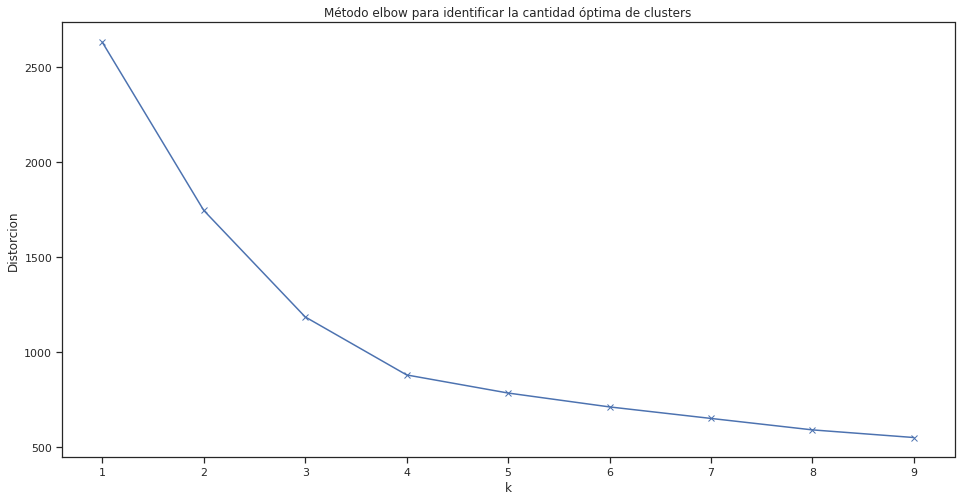

In [ ]:

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(beers_norm)
    distortions.append(kmeanModel.inertia_)
    print(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distorcion')
plt.title('Método elbow para identificar la cantidad óptima de clusters')
plt.show()

No se observa un codo muy claro, pero iremos con 4

In [ ]:
cluster_11features = KMeans(n_clusters=4, random_state=0).fit(beers_norm.values)
y = cluster_11features.predict(beers_norm.values)

In [ ]:
pd.Series(y).value_counts()

0    4272
2    4122
3    1507
1     928
dtype: int64

In [ ]:
pd.DataFrame(cluster_11features.cluster_centers_,columns=used_columns).describe()


,review_id,overall,taste,palate,aroma,appearance,alcohol_by_volume,profilename,year_min,year_max,brewery_name
count,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000e+00
mean,0.048800,0.677837,0.649465,0.658725,0.645314,0.675643,0.155773,0.048800,0.569680,0.892453,2.500000e-01
std,0.043887,0.117300,0.135431,0.126184,0.143237,0.133734,0.027172,0.043887,0.197596,0.024134,5.000000e-01
min,0.018037,0.503210,0.448416,0.472180,0.433097,0.477002,0.120469,0.018037,0.370014,0.870616,-2.317591e-15
25%,0.020536,0.667049,0.632620,0.639720,0.623064,0.657749,0.141373,0.020536,0.442636,0.872038,2.792905e-15
50%,0.032363,0.726242,0.704034,0.707457,0.703856,0.731030,0.162587,0.032363,0.542730,0.892853,4.558853e-15
75%,0.060626,0.737029,0.720879,0.726462,0.726106,0.748924,0.176986,0.060626,0.669775,0.913268,2.500000e-01
max,0.112438,0.755653,0.741378,0.747808,0.740445,0.763511,0.177448,0.112438,0.823246,0.913491,1.000000e+00


In [ ]:
threefeatures = beers_norm[['brewery_name','aroma','year_min']]

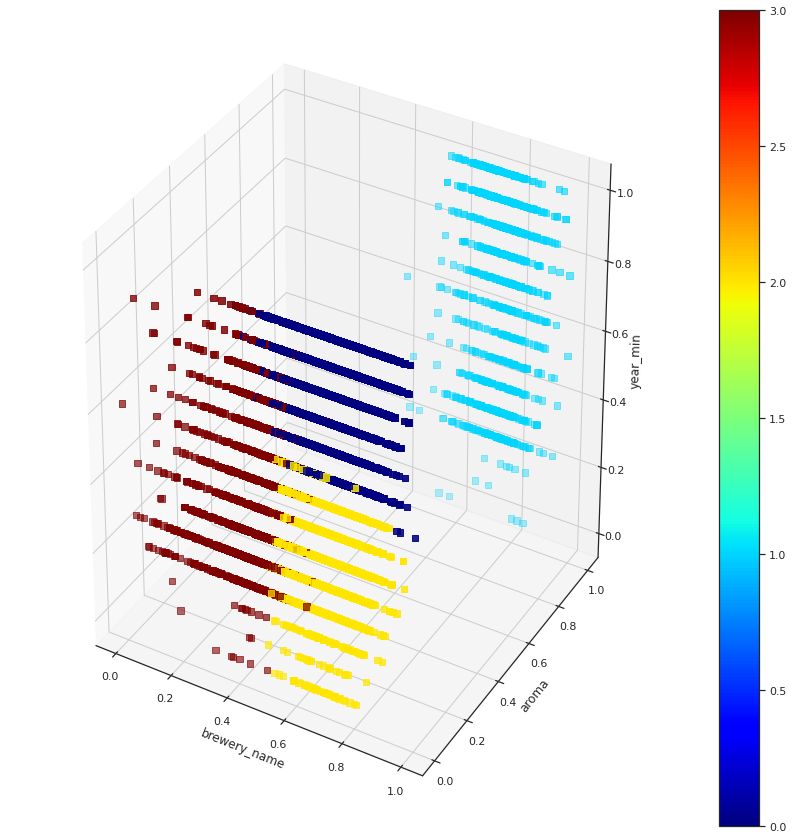

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
x1 = np.array(threefeatures.values[:,1])
x2 = np.array(threefeatures.values[:,0])
x3 = np.array(threefeatures.values[:,2])
ax.set_ylabel('aroma')
ax.set_xlabel('brewery_name')
ax.set_zlabel('year_min')
pos = ax.scatter(x1,x2,x3, marker="s", c=y, s=40, cmap="jet")
fig.colorbar(pos, ax=ax)
plt.show()

Observamos que el amarillo es un grupo de cervezas de buena marca, y con bastantes años de trayectoria, pero baja puntuación de aroma. Similarmente, las azules son también de aroma regular y buena marca, pero más recientes. 

Luego el grupo celeste son cervezas de muy buen aroma y de buena marca, con una antiguedad variada. Estas serían las más recomendables.

Por último el grupo rojo son cervezas de marcas poco conocidas o de bajas calificaciones, y también tienen baja puntuación de aroma, por lo que no serían recomendables


In [ ]:
names = {0:'azul',1:'celeste',2:'amarillo',3:'rojo'}

for cluster_number in range(4):
  print('\n'+names[cluster_number].upper())
  print(beers[y==cluster_number].beer_style.value_counts()[:15])
  



AZUL
American IPA                        355
American Double / Imperial IPA      283
American Double / Imperial Stout    199
American Pale Ale (APA)             165
American Porter                     157
Saison / Farmhouse Ale              155
Russian Imperial Stout              149
American Wild Ale                   137
American Amber / Red Ale            116
Belgian Strong Dark Ale              97
American Strong Ale                  93
Belgian Strong Pale Ale              88
American Black Ale                   79
Witbier                              77
American Barleywine                  75
Name: beer_style, dtype: int64

CELESTE
American IPA                        57
American Double / Imperial IPA      48
American Strong Ale                 45
American Pale Ale (APA)             37
American Barleywine                 34
Belgian Strong Pale Ale             32
American Porter                     30
Russian Imperial Stout              29
American Double / Imperial Stout    28
Fru

In [ ]:
cluster_number=1 #Las recomendables
print('\n'+names[cluster_number].upper())
namesbeers = beers[y==cluster_number].index[:15]

print(namesbeers.values)


CELESTE
['90 Minute IPA' 'Sierra Nevada Celebration Ale' 'Stone Ruination IPA'
 'Arrogant Bastard Ale' 'Two Hearted Ale' 'Stone IPA (India Pale Ale)'
 'Sierra Nevada Pale Ale' 'La Fin Du Monde' 'Founders Breakfast Stout'
 'Sierra Nevada Bigfoot Barleywine Style Ale' 'Pliny The Elder'
 '60 Minute IPA' 'Storm King Stout' 'Samuel Adams Boston Lager'
 "Bell's Hopslam Ale"]


Si disfrutas una buena IPA, recomendamos probar la 90 minute IPA. 